In [18]:
import os
import numpy as np
np.random.seed(2020)
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, BatchNormalization

from keras.preprocessing import image
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam

from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input, decode_predictions

%matplotlib inline

In [19]:
df = pd.read_csv('artists.csv')

In [20]:
df.head()

,id,name,years,genre,nationality,bio,wikipedia,paintings
0,0,Amedeo Modigliani,1884 - 1920,Expressionism,Italian,Amedeo Clemente Modigliani (Italian pronunciat...,http://en.wikipedia.org/wiki/Amedeo_Modigliani,193
1,1,Vasiliy Kandinskiy,1866 - 1944,"Expressionism,Abstractionism",Russian,Wassily Wassilyevich Kandinsky (Russian: Васи́...,http://en.wikipedia.org/wiki/Wassily_Kandinsky,88
2,2,Diego Rivera,1886 - 1957,"Social Realism,Muralism",Mexican,Diego María de la Concepción Juan Nepomuceno E...,http://en.wikipedia.org/wiki/Diego_Rivera,70
3,3,Claude Monet,1840 - 1926,Impressionism,French,Oscar-Claude Monet (; French: [klod mɔnɛ]; 14 ...,http://en.wikipedia.org/wiki/Claude_Monet,73
4,4,Rene Magritte,1898 - 1967,"Surrealism,Impressionism",Belgian,René François Ghislain Magritte (French: [ʁəne...,http://en.wikipedia.org/wiki/René_Magritte,194


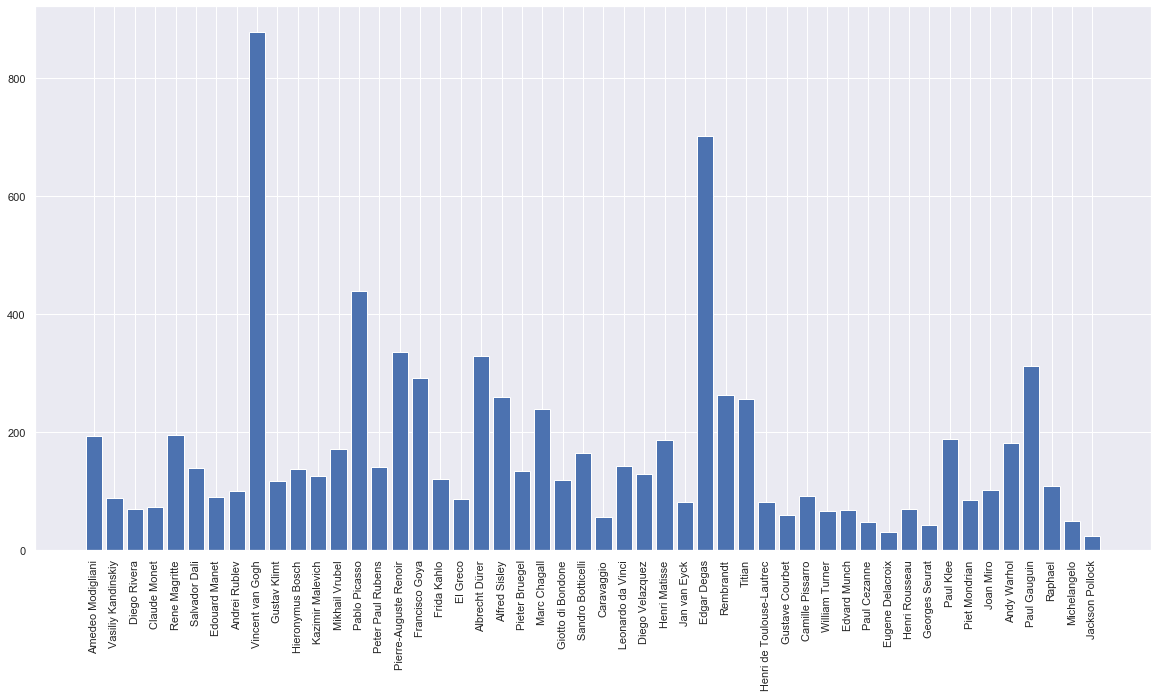

In [21]:
plt.figure(figsize=(20, 10))
plt.bar(df['name'], df['paintings'])
plt.xticks(rotation=90);

In [22]:
artists = df[df['paintings'] > 100][['name', 'paintings']].reset_index(drop=True)

In [23]:
artists['weights'] = artists['paintings'].sum() / (artists['paintings'] * artists.shape[0])
artists

,name,paintings,weights
0,Amedeo Modigliani,193,1.224698
1,Rene Magritte,194,1.218385
2,Salvador Dali,139,1.700480
3,Vincent van Gogh,877,0.269517
4,Gustav Klimt,117,2.020228
5,Hieronymus Bosch,137,1.725304
6,Kazimir Malevich,126,1.875926
7,Mikhail Vrubel,171,1.382261
8,Pablo Picasso,439,0.538421
9,Peter Paul Rubens,141,1.676359


In [24]:
class_weights = artists['weights'].to_dict()

In [25]:
top_artists = artists['name'].str.replace(' ', '_')

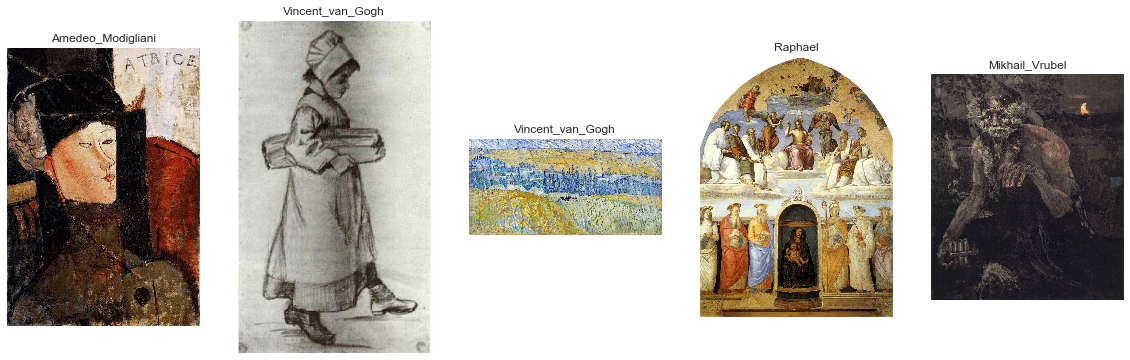

In [26]:
image_path = './images/'
artist_path = os.listdir(image_path)

fig, axes = plt.subplots(1, 5, figsize=(20, 10))

for i in range(5):
    random_artist = np.random.choice(top_artists)
    random_picture = np.random.choice(os.listdir(os.path.join(image_path, random_artist)))
    img = plt.imread(os.path.join(image_path, random_artist, random_picture))
    
    axes[i].set_title(random_artist)
    axes[i].imshow(img)
    axes[i].axis('off')

In [27]:
input_shape = (224, 224, 3)
output_shape = top_artists.shape[0]
n_batches = 16

In [28]:
data_generator = image.ImageDataGenerator(validation_split=0.2,
                                         rescale=1./255.,
                                         zoom_range=0.5,
                                         horizontal_flip=True,
                                         vertical_flip=True,
                                         rotation_range=15,
                                         #fill_mode='wrap'
                                         )

In [29]:
train_datagen = data_generator.flow_from_directory(directory=image_path,
                                                  class_mode='categorical',
                                                  target_size=input_shape[:2],
                                                  subset='training',
                                                  shuffle=True,
                                                  classes=top_artists.to_list(),
                                                  batch_size=n_batches)

valid_datagen = data_generator.flow_from_directory(directory=image_path,
                                                  class_mode='categorical',
                                                  target_size=input_shape[:2],
                                                  subset='validation',
                                                  shuffle=True,
                                                  classes=top_artists.to_list(),
                                                  batch_size=n_batches)

Found 5687 images belonging to 30 classes.
Found 1404 images belonging to 30 classes.


### ResNet50

In [30]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [31]:
for layer in base_model.layers:
    layer.trainable = False

for layer in base_model.layers[:60]:
    layer.trainable = True

In [32]:
rn_model = Sequential([
    base_model,
    
    Flatten(),
    
    Dense(512, kernel_initializer='he_uniform', activation='relu'),
    Dropout(0.3),
    BatchNormalization(),
    
    Dense(32, kernel_initializer='he_uniform', activation='relu'),
    #Dropout(0.2),
    BatchNormalization(),
    
    Dense(output_shape, activation='softmax')
    ])

rn_model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])
rn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten_1 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               51380736  
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 512)               2048      
_________________________________________________________________
dense_4 (Dense)              (None, 32)                16416     
_________________________________________________________________
batch_normalization_3 (Batch (None, 32)               

In [33]:
callbacks = [ 
    ReduceLROnPlateau(patience=3), 
    EarlyStopping(patience=5)
]

In [34]:
rn_model.fit_generator(generator=train_datagen, steps_per_epoch=train_datagen.n/n_batches, 
                        validation_data=valid_datagen, validation_steps=valid_datagen.n/n_batches,
                        epochs=20,
                        verbose=1,
                        shuffle=True,
                        callbacks=callbacks,
                        class_weight=class_weights,
                        use_multiprocessing=True,
                        workers=-1
                       )

Epoch 1/20
356/355 [==============================] - 3245s 9s/step - loss: 2.8031 - accuracy: 0.2295 - val_loss: 6.0736 - val_accuracy: 0.0235 - lr: 1.0000e-04
Epoch 2/20
356/355 [==============================] - 2822s 8s/step - loss: 2.2322 - accuracy: 0.3670 - val_loss: 3.7880 - val_accuracy: 0.0762 - lr: 1.0000e-04
Epoch 3/20
356/355 [==============================] - 2692s 8s/step - loss: 2.0428 - accuracy: 0.4201 - val_loss: 2.3534 - val_accuracy: 0.3789 - lr: 1.0000e-04
Epoch 4/20
356/355 [==============================] - 2673s 8s/step - loss: 1.8826 - accuracy: 0.4633 - val_loss: 2.0631 - val_accuracy: 0.4758 - lr: 1.0000e-04
Epoch 5/20
356/355 [==============================] - 2653s 7s/step - loss: 1.7769 - accuracy: 0.4953 - val_loss: 1.9540 - val_accuracy: 0.4843 - lr: 1.0000e-04
Epoch 6/20
356/355 [==============================] - 2580s 7s/step - loss: 1.7160 - accuracy: 0.5059 - val_loss: 1.9579 - val_accuracy: 0.4729 - lr: 1.0000e-04
Epoch 7/20
356/355 [==============

In [36]:
train_score = rn_model.evaluate_generator(train_datagen, verbose=1)
print('Train score: ', train_score[1])

356/356 [==============================] - 662s 2s/step - loss: 0.9599 - accuracy: 0.7522
Train score:  0.7522419691085815


In [37]:
valid_score = rn_model.evaluate_generator(valid_datagen, verbose=1)
print('Valid score: ', valid_score[1])

88/88 [==============================] - 161s 2s/step - loss: 1.4078 - accuracy: 0.6332
Valid score:  0.6331908702850342
